Linus code

In [ ]:
# Install package to be able to save keras weights
pip install h5py

In [ ]:
pip install nibabel

In [ ]:
# Mount google drive
from google.colab import drive
import os
drive.mount('my_drive', force_remount=True)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import keras.backend as K
import json
import psutil
import glob
import nibabel as nib
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def print_memory_use():
    '''
    Function which prints current python memory usage
    '''
    process = psutil.Process(os.getpid())
    print(process.memory_info().rss/1e9)

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

mapping2 = {
    0: "Null class",
    1: "Tumor",
}

# fixme: skulle gå att göra bättre igenom att skicka med en tex tuple med titlarna
# och returnera ett matplotlib-objekt istället för då hade man inte behövt ha olika
# funktioner för "plot_modalities" och "plt_OHE" och också kunna ha två stycken figurer med 
# 2*2 subplots i en cell.
def plot_modalities(x):
    # Make sure input data is of correct shape
    assert x.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(x[:,:,0])
    plt.axis('off')
    plt.title('T1')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(x[:,:,1])
    plt.axis('off')
    plt.title('T1ce')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(x[:,:,2])
    plt.axis('off')
    plt.title('T2')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(x[:,:,3])
    plt.axis('off')
    plt.title('FLAIR')
    plt.colorbar()
    plt.show()

def plot_OHE(y):
    # Make sure input data is of correct shape
    assert y.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(y[:,:,0])
    plt.axis('off')
    plt.title('Null')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(y[:,:,1])
    plt.axis('off')
    plt.title('"Necrotic and non-enhancing tumor core"')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(y[:,:,2])
    plt.axis('off')
    plt.title('Edema')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(y[:,:,3])
    plt.axis('off')
    plt.title('GD-enhancing tumor')
    plt.colorbar()
    plt.show()

def shift_and_scale(x):
    assert len(x.shape) == 2, 'The input must be 2 dimensional'
    #assert np.std(x) != 0, 'Cant divide by zero'
    result = x - np.mean(x)
    
    # This is a really ugly hack
    if np.std(x) == 0:
        result /= 1
    else:
        result /= np.std(x)
    return result

def OHE(Y, mapping):
    '''
    Takes in a picture as a matrix with labels and returns a one hot encoded tensor
    
    Parameters:
    Y is the picture
    Mapping is what value corresponds to what label
    
    Returns:
    A tensor with a channel for each label.
    '''
    shape = Y.shape
    labels = mapping.keys()
    one_hot_enc = np.zeros(list(shape) + [len(labels)])
    
    for i, label in enumerate(labels):
        temp = np.zeros(shape)
        ind = Y == label
        temp[ind] = 1
        one_hot_enc[:, :, i] = temp
    return one_hot_enc

def OHE2(Y):
    '''

    '''
    shape = Y.shape
    # fixme: Having a OHE-encoding now is unnecessary
    # 1 channels encodes all informations
    one_hot_enc = np.zeros(list(shape) + [2])
    temp = np.zeros(shape)
    temp2 = np.ones(shape)
    
    ind1 = Y == 1
    ind2 = Y == 4
    temp[ind1] = 1
    temp[ind2] = 1
    
    temp2 = temp2 - temp
    
    one_hot_enc[:, :, 0] = temp
    one_hot_enc[:, :, 1] = temp2
    return one_hot_enc

def convert_brats(Y):
    '''

    '''
    shape = Y.shape
    # fixme: Having a OHE-encoding now is unnecessary
    # 1 channels encodes all informations
    result = np.zeros(shape)
    temp = np.zeros(shape)
    
    ind1 = Y == 1
    ind2 = Y == 4
    temp[ind1] = 1
    temp[ind2] = 1
    
    result = temp
    return result

#fixme: I don't know if providing this mapping is necessary
# probably could be provided inside function instead.
def OHE_uncoding(y, mapping):
    result = np.argmax(y, axis=2)
    labels = mapping.keys()
    temp = np.zeros(result.shape)
    for i, label in enumerate(labels):
        ind = result == i
        temp[ind] = label
    return temp

def IoU_wholeTumor(y_true, y_pred):
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    
    y_pred[:,:,0] = np.logical_not(y_pred[:,:,0]) 
    y_true[:,:,0] = np.logical_not(y_true[:,:,0])
    
    intersection = np.logical_and(y_pred[:,:,0], y_true[:,:,0])
    union = np.logical_or(y_true[:,:,0], y_pred[:,:,0])
    
    size_int = np.count_nonzero(intersection)
    size_uni = np.count_nonzero(union)
    
    return size_int/size_uni

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + 1e-8)

def IoU(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    return intersection/sum_

def ful_IoU(y_true, y_pred):
    intersection = K.cast(np.sum(K.eval(y_true)[:,0] == K.eval(y_pred)[:,0]), dtype='float32')
    y1 = (K.eval(y_true)[:,0] > 0)
    y2 = (K.eval(y_pred)[:,0] > 0)
    union = K.cast(np.sum((y1 + y2) > 0), dtype='float32')
    return intersection/union

def confusion_matrix(y_true, y_pred):
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    p_00 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,0]))
    p_11 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,1]))
    p_22 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,2]))
    p_33 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,3]))

    f_10 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,1]))
    f_20 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,2]))
    f_30 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,3]))

    f_01 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,0]))
    f_21 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,2]))
    f_31 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,3]))

    f_02 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,0]))
    f_12 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,1]))
    f_32 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,3]))

    f_03 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,0]))
    f_13 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,1]))
    f_23 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,2]))

    conf_matrix = np.array([p_00, f_01, f_02, f_03,
                            f_10,p_11, f_12, f_13, 
                            f_20, f_21, p_22, f_23, 
                            f_30, f_31, f_32, p_33])
    conf_matrix = conf_matrix.reshape(4,4)
    
    return conf_matrix

def reset_config(config, config_path=None, weights_path=None):
    new_config = config
    if weights_path:
        assert type(weights_path) == str, 'The weight path must be a string'
        new_config['weights_path'] = weights_path
    if config_path:
        assert type(config_path) == str, 'The config path must be a string'
        new_config['config_path'] = config_path
    new_config['history']['training_samples_used'] = 0
    new_config['history']['loss'] = []
    new_config['history']['val_loss'] = []
    new_config['keep_training'] = False

class CallbackJSON(Callback):
    """ CallbackJSON descends from Callback
        and is used to write the number of training samples that the model has been trained on
        and the loss for a epoch
    """
    def __init__(self, config):
        """Save params in constructor
        config: Is a dictionary loaded from a JSON file which is used to keep track of training
        """
        self.config = config
        self.config_path = config['config_path']

    def on_epoch_end(self, epoch, logs):
        """
        Updates the history of the config dict and saves it to a file
        """
        # How many effective training samples have been used
        self.config['history']['training_samples_used'] += self.config['samples_used']
        
        # Logs the loss of the current epoch
        self.config['history']['loss'].append(logs['loss'])
        #fixme: add the same code but for "val_loss"
        self.config['history']['val_loss'].append(logs['val_loss'])
        
        print_memory_use()
        # Save new config file
        with open(self.config_path, "w") as f:
            f.write(json.dumps(self.config))

def load_patients(i, j, num_classes, base_path=""):
    assert j >= i, 'j>i has to be true, you have given an invalid range of patients.'
    
    path = base_path + "MICCAI_BraTS_2019_Data_Training/*/*/*"
    
    wild_t1 = path + "_t1.nii.gz"
    wild_t1ce = path + "_t1ce.nii.gz"
    wild_t2 = path + "_t2.nii.gz"
    wild_flair = path + "_flair.nii.gz"
    wild_gt = path + "_seg.nii.gz"
    
    t1_paths = glob.glob(wild_t1)
    t1ce_paths = glob.glob(wild_t1ce)
    t2_paths = glob.glob(wild_t2)
    flair_paths = glob.glob(wild_flair)
    gt_paths = glob.glob(wild_gt)

    num_patients = j - i
    ind = []
    num_non_empty_slices = 0

    for i in range(i, i + num_patients):
        path_gt = gt_paths[i]
        img_gt = nib.load(path_gt)
        img_gt = img_gt.get_fdata()

        curr_patient = []
        # quick and dirty way to only get slices with tumor
        for j in range(img_gt.shape[-1]):
            if len(np.unique(img_gt[:,:,j])) >= num_classes:
                curr_patient.append(j)
                num_non_empty_slices += 1
        ind.append(curr_patient)

    image_data = np.zeros((4, 240, 240, num_non_empty_slices))
    labels = np.zeros((num_non_empty_slices, 240, 240))
    OHE_labels = np.zeros((num_non_empty_slices, 240, 240, 4))
    next_ind = 0

    for i in range(num_patients):
        print('Patient: ' + str(i))
        curr_ind = ind[i]

        path_t1 = t1_paths[i]
        path_t1ce = t1ce_paths[i]
        path_t2 = t2_paths[i]
        path_flair = flair_paths[i]
        path_gt = gt_paths[i]

        img_t1 = nib.load(path_t1)
        img_t1ce = nib.load(path_t1ce)
        img_t2 = nib.load(path_t2)
        img_flair = nib.load(path_flair)
        img_gt = nib.load(path_gt)

        img_t1 = img_t1.get_fdata()
        img_t1ce = img_t1ce.get_fdata()
        img_t2 = img_t2.get_fdata()
        img_flair = img_flair.get_fdata()
        img_gt = img_gt.get_fdata()

        temp = 0
        for i, x in enumerate(curr_ind):
            image_data[0, :, :, next_ind + i] = img_t1[:,:,x]
            image_data[1, :, :, next_ind + i] = img_t1ce[:,:,x]
            image_data[2, :, :, next_ind + i] = img_t2[:,:,x]
            image_data[3, :, :, next_ind + i] = img_flair[:,:,x]
            labels[next_ind + i,:,:] = img_gt[:,:,x]
            temp += 1
        next_ind += temp

    # I have here chosen to do shift and scale per image, 
    # which is not the only way to do normalization.
    for j in range(num_non_empty_slices):
        # shift and scale data
        image_data[0, :, :, j] = shift_and_scale(image_data[0, :, :, j])
        image_data[1, :, :, j] = shift_and_scale(image_data[1, :, :, j])
        image_data[2, :, :, j] = shift_and_scale(image_data[2, :, :, j])
        image_data[3, :, :, j] = shift_and_scale(image_data[3, :, :, j])

        OHE_labels[j, :, :, :] = OHE(labels[j, :, :], mapping)

    # The last axis will become the first axis
    image_data = np.moveaxis(image_data, -1, 0)
    image_data = np.moveaxis(image_data, 1, 3)
    return (image_data, OHE_labels)

def load_patients2(i, j, base_path=""):
    assert j >= i, 'j>i has to be true, you have given an invalid range of patients.'
    
    path = base_path + "MICCAI_BraTS_2019_Data_Training/*/*/*"
    
    wild_t1ce = path + "_t1ce.nii.gz"
    wild_gt = path + "_seg.nii.gz"
    
    t1ce_paths = glob.glob(wild_t1ce)
    gt_paths = glob.glob(wild_gt)

    num_patients = j - i
    ind = []
    num_non_empty_slices = 0

    for k in range(i, j):
        path_gt = gt_paths[k]
        img_gt = nib.load(path_gt)
        img_gt = img_gt.get_fdata()

        curr_patient = []
        for l in range(img_gt.shape[-1]):
            labels_in_slice = set(np.unique(img_gt[:,:,l]))
            labels_of_interest = set([1,4])
            if labels_of_interest.issubset(labels_in_slice):
                curr_patient.append(l)
                num_non_empty_slices += 1
        ind.append(curr_patient)

    image_data = np.zeros((1, 240, 240, num_non_empty_slices))
    labels = np.zeros((num_non_empty_slices, 240, 240))
    OHE_labels = np.zeros((num_non_empty_slices, 240, 240, 2))
    next_ind = 0

    for k in range(len(ind)):
        print('Patient: ' + str(k))
        curr_ind = ind[k]

        path_t1ce = t1ce_paths[k]
        path_gt = gt_paths[k]

        img_t1ce = nib.load(path_t1ce)
        img_gt = nib.load(path_gt)

        img_t1ce = img_t1ce.get_fdata()
        img_gt = img_gt.get_fdata()

        temp = 0
        for l, x in enumerate(curr_ind):
            image_data[0, :, :, next_ind + l] = img_t1ce[:,:,x]
            labels[next_ind + l,:,:] = img_gt[:,:,x]
            temp += 1
        next_ind += temp

    for l in range(num_non_empty_slices):
        image_data[0, :, :, l] = shift_and_scale(image_data[0, :, :, l])
        OHE_labels[l, :, :, :] = OHE2(labels[l, :, :])

    # The last axis will become the first axis
    image_data = np.moveaxis(image_data, -1, 0)
    image_data = np.moveaxis(image_data, 1, 3)
    return (image_data, OHE_labels)

def load_patients3(i, j, base_path=""):
    assert j >= i, 'j>i has to be true, you have given an invalid range of patients.'
    
    path = base_path + "MICCAI_BraTS_2019_Data_Training/*/*/*"
    
    wild_t1ce = path + "_t1ce.nii.gz"
    wild_gt = path + "_seg.nii.gz"
    
    t1ce_paths = glob.glob(wild_t1ce)
    gt_paths = glob.glob(wild_gt)

    num_patients = j - i
    ind = []
    num_non_empty_slices = 0

    for k in range(i, i + num_patients):
        path_gt = gt_paths[k]
        img_gt = nib.load(path_gt)
        img_gt = img_gt.get_fdata()

        curr_patient = []
        # Get slices containing class 1 and 4
        for l in range(img_gt.shape[-1]):
            labels_in_slice = set(np.unique(img_gt[:,:,l]))
            labels_of_interest = set([1,4])
            if labels_of_interest.issubset(labels_in_slice):
                curr_patient.append(l)
                num_non_empty_slices += 1
        ind.append(curr_patient)

    image_data = np.zeros((1, 240, 240, num_non_empty_slices))
    labels = np.zeros((num_non_empty_slices, 240, 240))
    next_ind = 0

    for k in range(num_patients):
        print('Patient: ' + str(k))
        curr_ind = ind[k]

        path_t1ce = t1ce_paths[k]
        path_gt = gt_paths[k]

        img_t1ce = nib.load(path_t1ce)
        img_gt = nib.load(path_gt)

        img_t1ce = img_t1ce.get_fdata()
        img_gt = img_gt.get_fdata()

        temp = 0
        for l, x in enumerate(curr_ind):
            image_data[0, :, :, next_ind + l] = img_t1ce[:,:,x]
            labels[next_ind + l,:,:] = img_gt[:,:,x]
            temp += 1
        next_ind += temp

    # I have here chosen to do shift and scale per image, 
    # which is not the only way to do normalization.
    for l in range(num_non_empty_slices):
        # shift and scale data
        image_data[0, :, :, j] = shift_and_scale(image_data[0, :, :, l])
        labels[l, :, :] = convert_brats(labels[l, :, :])

    # The last axis will become the first axis
    image_data = np.moveaxis(image_data, -1, 0)
    image_data = np.moveaxis(image_data, 1, 3)
    return (image_data, labels)

def unet_binary(pretrained_weights = None, input_size = (256,256,1)):
    inputs = Input(input_size)
    #args = dict(activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [IoU, dice_coefficient])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

def unet(pretrained_weights = None, input_size = (256, 256, 1), num_classes=1, learning_rate=1e-4):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(num_classes, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)
    
    model = Model(input = inputs, output = activation)
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=[dice_coefficient])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

def unet_res(pretrained_weights = None, input_size = (256, 256, 4), num_classes=4, learning_rate=1e-4, dropout=0.5, this_activation='relu'):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Conv2D(input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    merge1 = Add()([inputs, conv1])
    merge1 = BatchNormalization()(merge1)
    merge1 = Activation(this_activation)(merge1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(merge1)
    
    conv2 = Conv2D(128, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Conv2D(input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    merge2 = Add()([pool1, conv2])
    merge2 = BatchNormalization()(merge2)
    merge2 = Activation(this_activation)(merge2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(merge2)
    
    conv3 = Conv2D(256, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    merge3 = Add()([pool2, conv3])
    merge3 = BatchNormalization()(merge3)
    merge3 = Activation(this_activation)(merge3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(merge3)
    
    conv4 = Conv2D(512, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(dropout)(conv4)
    drop4 = Conv2D(input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    merge4 = Add()([pool3, drop4])
    merge4 = BatchNormalization()(merge4)
    merge4 = Activation(this_activation)(merge4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(merge4)
    
    conv5 = Conv2D(1024, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(dropout)(conv5)
    drop5 = Conv2D(input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(drop5)
    merge5 = Add()([pool4, drop5])
    merge5 = BatchNormalization()(merge5)
    merge5 = Activation(this_activation)(merge5)
    
    up6 = Conv2D(input_size[-1], 2, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(merge5))
    merge6 = concatenate([merge4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(2*input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    merge6 = Add()([merge6, conv6])
    merge6 = BatchNormalization()(merge6)
    merge6 = Activation(this_activation)(merge6)
    
    up7 = Conv2D(input_size[-1], 2, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(merge6))
    merge7 = concatenate([merge3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(2*input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    merge7 = Add()([merge7, conv7])
    merge7 = BatchNormalization()(merge7)
    merge7 = Activation(this_activation)(merge7)
    
    up8 = Conv2D(input_size[-1], 2, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(merge7))
    merge8 = concatenate([merge2, up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2*input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    merge8 = Add()([merge8, conv8])
    merge8 = BatchNormalization()(merge8)
    merge8 = Activation(this_activation)(merge8)
    
    up9 = Conv2D(input_size[-1], 2, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(merge8))
    merge9 = concatenate([merge1, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(num_classes, 3, activation = this_activation, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2*input_size[-1], 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    merge9 = Add()([merge9, conv9])
    merge9 = BatchNormalization()(merge9)
    merge9 = Activation(this_activation)(merge9)
    
    merge10 = Conv2D(input_size[-1], 1, activation = 'linear', padding ='same', kernel_initializer = 'he_normal')(merge9)
    
    reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(merge10)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)
    
    model = Model(input = inputs, output = activation)
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=['accuracy'])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

def conv_block(input_, num_kernels, kernel_size, act_func, drop_rate):
    conv = Conv2D(num_kernels, kernel_size,activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(input_)
    conv = Conv2D(num_kernels, kernel_size, activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(conv)
    drop = Dropout(drop_rate)(conv)
    return conv

def conv_block(input_, num_kernels, kernel_size, act_func, drop_rate):
    argz = [num_kernels, kernel_size]
    kwargz = {'activation':act_func, 'padding':'same', 'kernel_initializer':'he_normal'}
    conv = Conv2D(*argz, **kwargz)(input_)
    conv = Conv2D(*argz, **kwargz)(conv)
    drop = Dropout(drop_rate)(conv)
    return conv

def conv_block_resnet(input_, num_kernels, kernel_size, act_func, drop_rate, input_size):
    argz = [num_kernels, kernel_size]
    kwargz = {'activation':act_func, 'padding':'same', 'kernel_initializer':'he_normal'}
    conv = Conv2D(*argz, **kwargz)(input_)
    conv = Conv2D(*argz, **kwargz)(conv)
    conv = Conv2D(input_size[-1], (1,1), activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Dropout(drop_rate)(conv)
    merge = Add()([input_, conv])
    merge = BatchNormalization()(merge)
    merge = Activation(act_func)(merge)
    return merge

def down_sampling_block(input_, act_func, num_kernels, drop_rate, input_size, res=False):
    if res:
        skip = conv_block_resnet(input_=input_, num_kernels=num_kernels, kernel_size=(3,3), 
                                 act_func=act_func, drop_rate=drop_rate, input_size=input_size)
    else:
        skip = conv_block(input_, num_kernels=num_kernels, kernel_size=(3,3), act_func=act_func, drop_rate=drop_rate)
    pool = MaxPooling2D(pool_size = (2, 2))(skip)
    return skip, pool

def up_sampling_block(input_, skip, act_func, num_kernels, drop_rate, input_size, res=False):
    up = UpSampling2D(size = (2, 2))(input_)
    merge = concatenate([skip, up], axis = 3)
    if res:
        conv = conv_block_resnet(up, num_kernels=num_kernels, kernel_size=(3,3), 
                                 act_func=act_func, drop_rate=drop_rate, input_size=input_size)
    else:
        conv = conv_block(merge, num_kernels, (3,3), act_func, drop_rate)
    return conv

def unet_clean(pretrained_weights = None, input_size = (256, 256, 1), num_classes=2, learning_rate=1e-4, act_func='relu', res=False):
    # Encoder
    inputs = Input(input_size)
    skip1, pool1 = down_sampling_block(inputs, act_func, num_kernels=64, drop_rate=0, input_size = input_size, res=res)
    skip2, pool2 = down_sampling_block(pool1, act_func, num_kernels=128, drop_rate=0, input_size = input_size, res=res)
    skip3, pool3 = down_sampling_block(pool2, act_func, num_kernels=256, drop_rate=0, input_size = input_size, res=res)
    skip4, pool4 = down_sampling_block(pool3, act_func, num_kernels=512, drop_rate=0.2, input_size = input_size, res=res)
    
    #Bottleneck
    conv5 = conv_block(pool4, 1024, 3, act_func, drop_rate=0.2)
    
    # Decoder
    conv6 = up_sampling_block(conv5, skip4, act_func, 512, drop_rate = 0.2, input_size = input_size, res=res)
    conv7 = up_sampling_block(conv6, skip3, act_func, 256, drop_rate = 0, input_size = input_size, res=res)
    conv8 = up_sampling_block(conv7, skip2, act_func, 128, drop_rate = 0, input_size = input_size, res=res)
    conv9 = up_sampling_block(conv8, skip1, act_func, 64, drop_rate = 0, input_size = input_size, res=res)
    conv9 = Conv2D(num_classes, 1, activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(conv9)

    reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)
    
    model = Model(input = inputs, output = activation)
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=['accuracy'])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

def unet_depth(pretrained_weights = None, input_size = (256, 256, 1), num_classes=2, learning_rate=1e-4, act_func='relu', res=False, 
               depth=4, num_kernels = [64, 128, 256, 512]):
    assert depth == len(num_kernels), 'Depth and number of kernel sizes must be equal'
    
    encoder = []
    inputs = Input(input_size)
    for i in range(depth):
        if i == 0:
            skip, conv = down_sampling_block(inputs, act_func, num_kernels=num_kernels[i], drop_rate=0, input_size = input_size, res=res)
            result = [skip, conv]
            encoder.append(result)
        else:
            skip, conv = down_sampling_block(encoder[i-1][1], act_func, num_kernels=num_kernels[i], drop_rate=0, input_size = input_size, res=res)
            result = [skip, conv]
            encoder.append(result)

    bottleneck = conv_block(encoder[depth - 1][1], 1024, 3, act_func, drop_rate=0.2)

    decoder = []
    for i in range(depth):
        if i == 0:
            skip = encoder[depth - 1][0]
            decoder.append(up_sampling_block(bottleneck, skip, act_func, num_kernels=num_kernels[depth - i - 1], drop_rate=0, input_size = input_size, res=res))
        else:
            skip = encoder[depth - i - 1][0]
            decoder.append(up_sampling_block(decoder[i - 1], skip, act_func, num_kernels=num_kernels[depth - i - 1], drop_rate=0, input_size = input_size, res=res))
            
    # prepare for softmax
    conv = Conv2D(num_classes, 1, activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(decoder[depth - 1])
    reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)
    
    # Compile model and load pretrained weights
    model = Model(input = inputs, output = activation)
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=['accuracy'])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

print('Finished')
print_memory_use()

Finished
0.734507008


In [10]:
#from my_lib import *
from os import listdir
import os

# Set name of who is running the script to determine which path to use
name = "linus"

# Code snippet to fix that colab notebook and local notebook access data
# through different paths
var = os.uname()
run_on_colab = var[0] == "Linux"

carl_path = "/content/my_drive/My Drive/Plugg/"
linus_path = "/content/my_drive/My Drive/"

if name == "linus":
  path = linus_path
else:
  path = carl_path

if run_on_colab:
    base_path = path + "EXJOBB/"
else:
    base_path = ''

# Much cleaner loading of patients
train_data = load_patients2(i=0, j=4, base_path=base_path)
val_data = load_patients2(i=269, j=272, base_path=base_path)

print('Finished')
print_memory_use()

Patient: 0
Patient: 1
Patient: 2
Patient: 3
Patient: 0
Patient: 1
Patient: 2
Finished
1.083162624


Separate input and labels and validate that the loading of the data has been done correctly

(184, 240, 240, 1)
(184, 240, 240, 2)


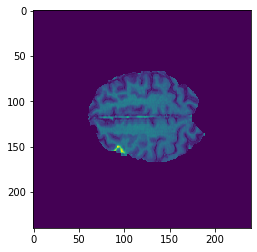

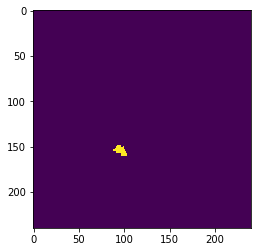

In [11]:
X_train = train_data[0]
Y_train = train_data[1]

X_val = val_data[0]
Y_val = val_data[1]

print(X_train.shape)
print(Y_train.shape)

# This will show a slice of a patient
ind = 70
patient = X_train[ind, :, :, :]
patient_labels = Y_train[ind, :, :]
plt.imshow(patient[:,:,0])
plt.show()
plt.imshow(patient_labels[:,:,0])


# New main training cell

In [12]:
# Load config file to session here
if run_on_colab:
    config_path = path + "EXJOBB/training_sessions/trainin_tumor_slices_only/config.json"
    weights_path = path + "EXJOBB/training_sessions/trainin_tumor_slices_only/weights.json"
    config_path = "/content/my_drive/My Drive/EXJOBB/training_sessions/tumor_slices_with_all_classes/config.json"
else:
    config_path = "config_0.json"

with open(config_path, 'r') as config_file:
    config = json.load(config_file)

# Reset file to empty loss-values and/or change paths to config and weights
weights_path = "Training_session_0/weights.h5"
config_path = "Training_session_0/config.json"
reset_config(config, config_path = config_path, weights_path=weights_path)

print(config)

{'weights_path': 'Training_session_0/weights.h5', 'config_path': 'Training_session_0/config.json', 'samples_used': 90, 'keep_training': False, 'history': {'training_samples_used': 0, 'loss': [], 'val_loss': []}}


In [16]:
# The path to where to save weights and initialize ModelCheckpoint
weights_path = config['weights_path']
from keras.callbacks import ModelCheckpoint, EarlyStopping
MyModelCheckPoint = ModelCheckpoint(weights_path, verbose=0, save_weights_only=True, period=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reset_config(config, config_path = config_path, weights_path=weights_path)

if config['keep_training'] == True:
    # Keep training on the old weights
    my_unet = unet(input_size = (240, 240, 1), num_classes=2, pretrained_weights = weights_path)
else:
    # Initialize network
    my_unet = unet(input_size = (240, 240, 1), num_classes=2)
    config['keep_training'] = True

assert not np.any(np.isnan(X_train)), 'Input contain nans'

#Y_train = Y_train.reshape(Y_train.shape[0], -1, 4)
validation_data = (X_val, Y_val.reshape(-1,240,240,1))

#plt.imshow(my_unet.predict(X_train[60, :, :].reshape(1,240,240,1)).reshape(240,240))

# Returns an object with accuracy and loss

history = my_unet.fit(x=X_train, 
                      y=Y_train.reshape(-1,240,240,1), 
                      batch_size=64,
                      epochs=100, 
                      verbose=1, 
                      callbacks=[CallbackJSON(config=config), MyModelCheckPoint, es],
                      validation_split=0.0, 
                      validation_data=validation_data, 
                      shuffle=True, 
                      class_weight=None, 
                      sample_weight=None, 
                      initial_epoch=0, 
                      steps_per_epoch=None, 
                      validation_steps=None, 
                      validation_freq=1)


W1105 10:36:29.873978 4370068928 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1105 10:36:29.890714 4370068928 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1105 10:36:29.893912 4370068928 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1105 10:36:29.919120 4370068928 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_p

InvalidArgumentError: You must feed a value for placeholder tensor 'softmax_1_target' with dtype float and shape [?,?,?]
	 [[node softmax_1_target (defined at /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541) ]]

Original stack trace for 'softmax_1_target':
  File "/Users/linuslagergren/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/linuslagergren/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/Users/linuslagergren/anaconda/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Users/linuslagergren/anaconda/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Users/linuslagergren/anaconda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-1cd0f21390fc>", line 14, in <module>
    my_unet = unet(input_size = (240, 240, 1), num_classes=2)
  File "<ipython-input-9-ac10ede335ff>", line 626, in unet
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=[dice_coefficient, ful_IoU])
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/engine/training.py", line 241, in compile
    dtype=K.dtype(self.outputs[i]))
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 541, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/linuslagergren/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
loss = config['history']['loss']
val_loss = config['history']['val_loss']
plt.plot(loss)
plt.show()
plt.plot(val_loss)
plt.show()

In [ ]:
ind = 10
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
my_unet.load_weights(config['weights_path'])

yhat = my_unet.predict(val_data[ind, :, :, :].reshape(1, 240, 240, 4))

#plot_OHE(yhat.reshape(240, 240, 4))

plotable = OHE_uncoding(yhat.reshape(240, 240, 4), mapping)
plt.imshow(plotable)
plt.show()
plt.imshow(val_labels[ind,:,:])

In [ ]:
config['weights_path'] = "/content/my_drive/My Drive/EXJOBB/training_sessions/100_epochs_10_patients_lr_1e-4/weights.h5"

In [ ]:
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

In [ ]:
#yhat = my_unet.predict(X_train[48].reshape(1,240,240,4))
yhat = my_unet.predict(X_train[0:100])
#yhat = yhat.reshape(240,240,4)
#plot_OHE(yhat)

In [ ]:

hist = plt.hist(yhat[:,:,0].reshape(-1), bins='auto', log=True)
plt.show()
hist = plt.hist(yhat[:,:,1].reshape(-1), bins='auto', log=True)
plt.show()
hist = plt.hist(yhat[:,:,2].reshape(-1), bins='auto', log=True)
plt.show()
hist = plt.hist(yhat[:,:,3].reshape(-1), bins='auto', log=True)
plt.show()